In [481]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import pandas as pd
from scipy.optimize import newton

data = pd.read_csv("data.csv")

In [482]:
select_maturity_dates = [
    "3/1/2025", "9/1/2025", "3/1/2026", "9/1/2026",
    "3/1/2027", "9/1/2027", "3/1/2028", "9/1/2028",
    "3/1/2029", "9/1/2029", "3/1/2030"
]
filtered_df = data[data["Maturity Date"].isin(select_maturity_dates)]
filtered_df['Maturity Date'] = pd.to_datetime(filtered_df['Maturity Date'])
sorted_df = filtered_df.sort_values(by='Maturity Date')
select_data = sorted_df.reset_index(drop=True)
select_data["Coupon"] = select_data["Coupon"].str.rstrip('%').astype(float) / 100

select_data.to_csv("selected_data.csv", index=False)
days_to_last_coupon = 90

dirty_prices = []   
for index, bond in select_data.iterrows():
    bond_row = {
        "ISIN": bond["ISIN"],
        "Coupon": bond["Coupon"],
        "Maturity Date": bond["Maturity Date"],
    }
    
    for i in [6, 7, 8, 9, 10, 13, 14, 15, 16, 17]:
        price = bond[f'{i}-Jan']
        accrued_interest = (bond["Coupon"] * 100) * (days_to_last_coupon / 365)
        dirty_price = price + accrued_interest
        bond_row[f'{i}-Jan Dirty Price'] = dirty_price
    
    dirty_prices.append(bond_row)

dirty_price_data = pd.DataFrame(dirty_prices)

dirty_price_data.to_csv("dirty_prices_per_bond.csv", index=False)

print(dirty_price_data)

            ISIN  Coupon Maturity Date  6-Jan Dirty Price  7-Jan Dirty Price  \
0   CA135087K528  0.0125    2025-03-01         100.038219         100.038219   
1   CA135087K940  0.0050    2025-09-01          98.523288          98.533288   
2   CA135087L518  0.0025    2026-03-01          97.051644          97.041644   
3   CA135087L930  0.0100    2026-09-01          97.256575          97.236575   
4   CA135087M847  0.0125    2027-03-01          96.928219          96.898219   
5   CA135087N837  0.0275    2027-09-01         100.308082         100.238082   
6   CA135087P576  0.0350    2028-03-01         102.683014         102.683014   
7   CA135087Q491  0.0325    2028-09-01         101.901370         101.941370   
8   CA135087Q988  0.0400    2029-03-01         105.056301         104.996301   
9   CA135087R895  0.0350    2029-09-01         103.083014         103.003014   
10  CA135087S471  0.0275    2030-03-01          99.488082          99.258082   

    8-Jan Dirty Price  9-Jan Dirty Pric

/tmp/ipykernel_38081/611161987.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Maturity Date'] = pd.to_datetime(filtered_df['Maturity Date'])


In [483]:
ytm_data = []
# Get current Toronto time
toronto_tz = pytz.timezone("America/Toronto")
toronto_time = datetime.now(toronto_tz)
toronto_time = pd.Timestamp(toronto_time)

In [484]:
dirty_price_data['Maturity Date'][0]

Timestamp('2025-03-01 00:00:00')

In [485]:
toronto_time

Timestamp('2025-02-03 14:27:13.995431-0500', tz='America/Toronto')

In [486]:
def month_difference(ts1: pd.Timestamp, ts2: pd.Timestamp):
    return abs((ts2.year - ts1.year) * 12 + (ts2.month - ts1.month))

ts1 = toronto_time
ts2 = dirty_price_data['Maturity Date'][0]

print(month_difference(ts1, ts2))


1


In [487]:
# 1-year bond YTM
def zero_coupon_ytm(price, face_value, time_to_maturity, coupon_rate):
    return ((face_value + coupon_rate/2 * 100) / price) ** (1 / time_to_maturity) - 1

def bond_price_function(ytm, face_value, coupon, freq, time_to_maturity, dirty_price):
    coupon_payment = coupon * face_value / freq
    n_payments = int(time_to_maturity * freq)
    t = np.linspace(0.5, np.floor(time_to_maturity), n_payments) + 1/6
    discount_factors = (1 + ytm) ** (-t)
    pv_coupons = coupon_payment * np.sum(discount_factors)
    pv_final = (face_value) * (1 + ytm) ** (-time_to_maturity)
    return pv_coupons + pv_final - dirty_price


    
def calculate_ytm(face_value, coupon, freq, time_to_maturity, dirty_price):
    if time_to_maturity < 0.5:
        return zero_coupon_ytm(dirty_price, face_value, time_to_maturity, coupon)
    try:
        initial_guess = coupon / face_value
        ytm = newton(bond_price_function, initial_guess, args=(face_value, coupon, freq, time_to_maturity, dirty_price))
        return ytm
    except RuntimeError:
        return np.nan

toronto_time = pd.Timestamp("2025-01-17")
ytm_results = []
dirty_price_data = pd.read_csv("dirty_prices_per_bond.csv")

for index, row in dirty_price_data.iterrows():
    current_date = toronto_time
    maturity_date = pd.Timestamp(row["Maturity Date"])
    coupon = row["Coupon"]
    freq = 2  # Semi-annual coupons
    
    row_ytm_data = []
    months_to_maturity = month_difference(current_date, maturity_date)
    time_to_maturity = months_to_maturity / 12

    for col_index, col_name in enumerate(row.index[3:]):
        dirty_price = row[col_name]
        ytm = calculate_ytm(100, coupon, freq, time_to_maturity, dirty_price)

        row_ytm_data.append(ytm)

    ytm_results.append(row_ytm_data)

ytm_df = pd.DataFrame(ytm_results)


In [488]:
ytm_df.to_csv("ytm_results.csv", index=False)

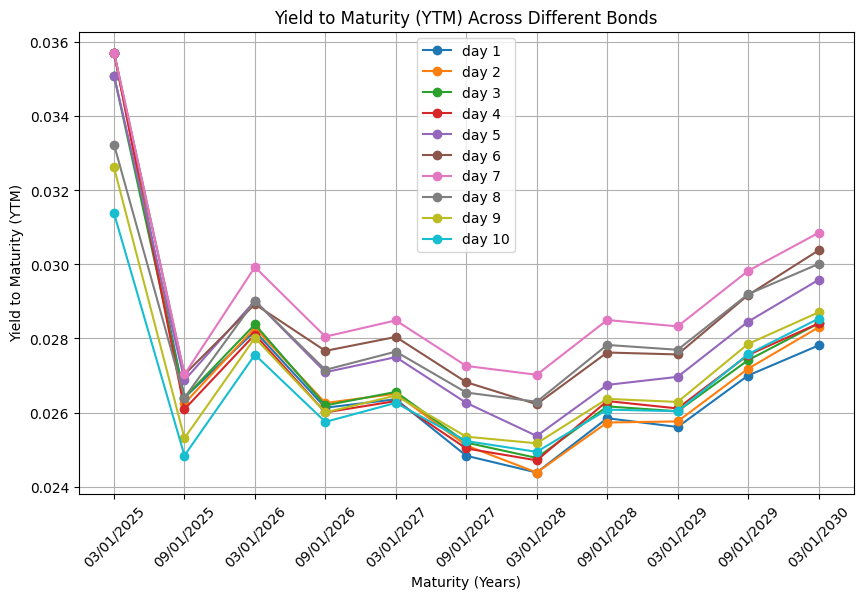

In [489]:
ytm_df = pd.read_csv("ytm_results.csv")
x_dates = pd.date_range(start="2025-03-01", end="2030-03-01", freq="6MS").strftime('%m/%d/%Y')

ytm_df.index = x_dates[:len(ytm_df)]
# plot each bond's YTM over time
plt.figure(figsize=(10,6))
for col in ytm_df.columns:
    day = int(col) + 1
    plt.plot(ytm_df.index, ytm_df[col], marker='o', linestyle='-', label=f"day {day}")

plt.xlabel("Maturity (Years)")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("Yield to Maturity (YTM) Across Different Bonds")
plt.xticks(rotation=45)
plt.legend(title="Days")
plt.legend()
plt.grid(True)

plt.show()


In [490]:
dirty_price_data = pd.read_csv("dirty_prices_per_bond.csv")
coupon_rates = dirty_price_data["Coupon"]
toronto_time = pd.Timestamp("2025-01-17")
maturity_day_fraction = []

for index, row_index in enumerate(coupon_rates):
    maturity_date = pd.Timestamp(dirty_price_data["Maturity Date"][index])
    months_to_maturity = month_difference(toronto_time, maturity_date)
    time_to_maturity = months_to_maturity / 12
    maturity_day_fraction.append(time_to_maturity)

**Question 2.**

In [491]:
def bootstrap_yield_curve(bonds):
    bonds = sorted(bonds, key=lambda x: x[2])
    freq = 2
    spot_dict = {}
    for price, coupon_rate, maturity in bonds:
        if maturity < 0.5:
            CF = 100 + coupon_rate/2 * 100
            z_new = (CF / price)**(1 / maturity) - 1
            spot_dict[maturity] = z_new
        else:
            n = int(round(maturity * freq))
            coupon_payment = 100 * coupon_rate / freq
            payment_times = [(i+1)/freq + 1/6 for i in range(n)]
            pv_known = 0.0
            for t in payment_times[:-1]:
                if t in spot_dict:
                    z_t = spot_dict[t]
                    pv_known += coupon_payment / ((1 + z_t)**t)
                else:
                    raise ValueError("Missing spot rate for time " + str(t))
            t_n = payment_times[-1]
            CF_final = coupon_payment + 100
            z_new = (CF_final / (price - pv_known))**(1/t_n) - 1
            spot_dict[t_n] = z_new
    return spot_dict


In [492]:
spot_rates = []

for index, col_index in enumerate(dirty_price_data.columns[3:]):
    dirty_price_data_col = dirty_price_data[col_index]
    bond_prices = dirty_price_data_col.values
    bonds = list(zip(bond_prices, coupon_rates, maturity_day_fraction))
    spot_rate = bootstrap_yield_curve(bonds)
    spot_rates.append(spot_rate)

spot_rates_df = pd.DataFrame(spot_rates)
spot_rates_df = spot_rates_df.transpose()
spot_rates_df['Maturity'] = maturity_day_fraction
spot_rates_df.to_csv("spot_rates.csv", index=False)



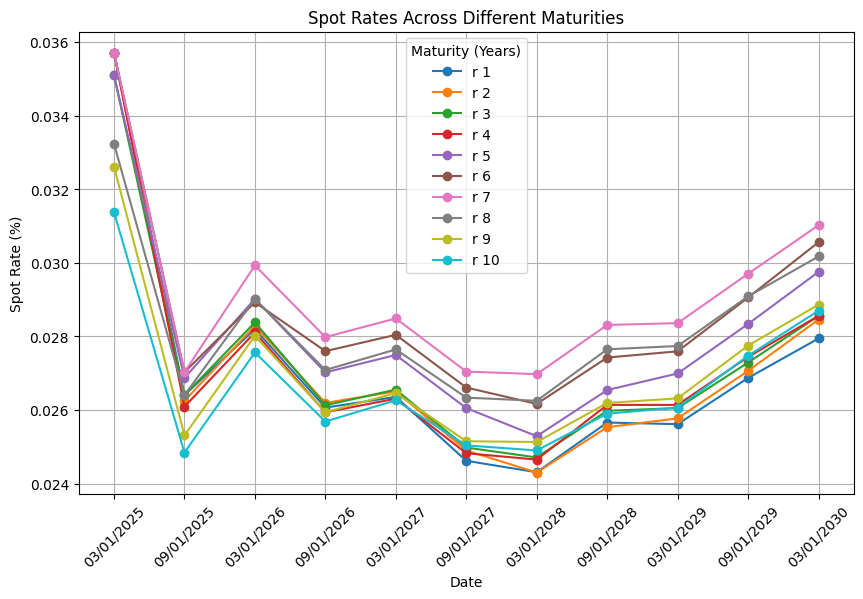

In [493]:
x_dates = pd.date_range(start="2025-03-01", end="2030-03-01", freq="6MS").strftime('%m/%d/%Y')

spot_rates_df.index = x_dates[:len(spot_rates_df)]  # Adjust index to match the dates

# Plot
plt.figure(figsize=(10, 6))

for col in spot_rates_df.columns[:10]:
    plt.plot(spot_rates_df.index, spot_rates_df[col], marker='o', linestyle='-', label=f"r {col+1}")
    
plt.xlabel("Date")
plt.ylabel("Spot Rate (%)")
plt.title("Spot Rates Across Different Maturities")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title="Maturity (Years)")
plt.grid(True)

plt.show()


In [494]:
def compute_forward_rate_df(t, n, df, day):
    df_sorted = df.sort_values(by='Maturity')
    maturities = df_sorted['Maturity'].to_numpy()[1:]
    rates = df_sorted[f'{day}'].to_numpy()[1:]
    S_t = np.interp(t, maturities, rates)
    S_tn = np.interp(t+n, maturities, rates)
    fwd = ((1 + S_tn)**(2*(t+n)) / (1 + S_t)**(2*t))**(1/(2*n)) - 1
    return fwd

In [495]:
spot_rates_df = pd.read_csv("spot_rates.csv")
forward_rates = {}

for column in spot_rates_df.columns[:10]:
    df = spot_rates_df[[column, 'Maturity']]
    forward_rate = [compute_forward_rate_df(1, n, df, column) for n in range(1, 5)]
    forward_rates[f'{column}'] = forward_rate

forward_rates_df = pd.DataFrame(forward_rates)
forward_rates_df = forward_rates_df
forward_rates_df.to_csv("forward_rates.csv", index=False)

In [496]:
print(forward_rates_df)

          0         1         2         3         4         5         6  \
0  0.024919  0.025194  0.025105  0.024935  0.026373  0.027496  0.027676   
1  0.022822  0.022951  0.023343  0.023350  0.024166  0.025325  0.026017   
2  0.024974  0.025054  0.025463  0.025707  0.026356  0.027286  0.028138   
3  0.027583  0.028089  0.028238  0.028373  0.029527  0.030500  0.030986   

          7         8         9  
0  0.026773  0.025457  0.025486  
1  0.025346  0.024150  0.024093  
2  0.027563  0.025994  0.025795  
3  0.030226  0.028837  0.028699  


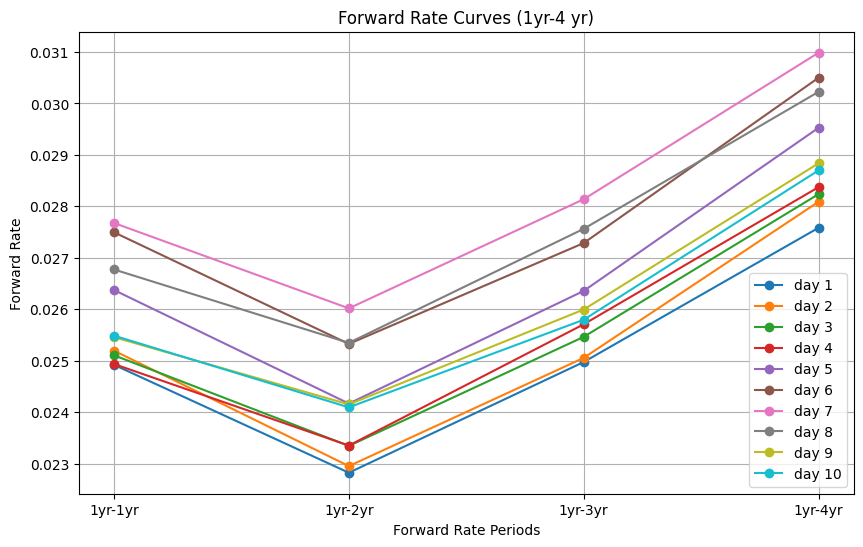

In [497]:
x_labels = ["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"]

if forward_rates_df.shape[0] >= len(x_labels):
    x_labels = x_labels[:forward_rates_df.shape[0]]

plt.figure(figsize=(10, 6))
for i in range(forward_rates_df.shape[1]):  # Iterate over columns (maturity dates)
    plt.plot(x_labels, forward_rates_df.iloc[:, i], marker='o', linestyle='-', label=f'day {i+1}')

plt.xlabel("Forward Rate Periods")
plt.ylabel("Forward Rate")
plt.title("Forward Rate Curves (1yr-4 yr)")
plt.legend()
plt.grid(True)
plt.show()


***Q3***

In [498]:
file_path_yield = "ytm_results.csv"
df_yield = pd.read_csv(file_path_yield)
# Randomly select 5 rows from the yield dataset
random_indices = np.random.choice(df_yield.shape[0], 5, replace=False)
df_yield_sample = df_yield.iloc[random_indices, :]
df_yield_log_returns_sample = np.log(df_yield_sample.iloc[:, 1:].values / df_yield_sample.iloc[:, :-1].values)
df_yield_log_returns_sample = pd.DataFrame(df_yield_log_returns_sample,
                                           columns=[f'Period {i}' for i in range(1, df_yield_sample.shape[1])])
cov_matrix_yield = np.cov(df_yield_log_returns_sample, rowvar=True)
df_cov_matrix_yield = pd.DataFrame(cov_matrix_yield,
                                    index=[f'Yield {i+1}' for i in random_indices],
                                    columns=[f'Yield {i+1}' for i in random_indices])
print(df_cov_matrix_yield)

          Yield 4   Yield 9   Yield 6   Yield 2   Yield 1
Yield 4  0.000672  0.000655  0.000705  0.000505  0.000361
Yield 9  0.000655  0.000713  0.000692  0.000512  0.000363
Yield 6  0.000705  0.000692  0.000748  0.000541  0.000319
Yield 2  0.000505  0.000512  0.000541  0.000423  0.000200
Yield 1  0.000361  0.000363  0.000319  0.000200  0.000800


In [499]:
file_path = "forward_rates.csv"
df_cov = pd.read_csv(file_path)
df_log_returns = np.log(df_cov.iloc[:, 1:].values / df_cov.iloc[:, :-1].values)
df_log_returns = pd.DataFrame(df_log_returns, columns=[f'Period {i}' for i in range(1, df_cov.shape[1])])

cov_matrix_forward = np.cov(df_log_returns, rowvar=True)

forward_labels = [f'Forward {i+1}' for i in range(4)]

df_cov_matrix_forward = pd.DataFrame(cov_matrix_forward,
                                     index=forward_labels,
                                     columns=forward_labels)

print(df_cov_matrix_forward)

           Forward 1  Forward 2  Forward 3  Forward 4
Forward 1   0.001086   0.000903   0.000813   0.000866
Forward 2   0.000903   0.000890   0.000850   0.000776
Forward 3   0.000813   0.000850   0.000867   0.000745
Forward 4   0.000866   0.000776   0.000745   0.000744


In [500]:
#eigenvalues and eigenvectors for the forward rate covariance matrix
eigenvalues_forward, eigenvectors_forward = np.linalg.eig(cov_matrix_forward)

#eigenvalues and eigenvectors for the yield covariance matrix
eigenvalues_yield, eigenvectors_yield = np.linalg.eig(cov_matrix_yield)

In [501]:
print(eigenvectors_forward)
print(eigenvectors_forward[:,1])

[[ 0.54407919  0.69638812  0.43968534 -0.16030667]
 [ 0.50561295 -0.25705994 -0.46608032 -0.67900285]
 [ 0.48347596 -0.6540966   0.52729424  0.24570188]
 [ 0.46323253  0.14533206 -0.55803829  0.67296916]]
[ 0.69638812 -0.25705994 -0.6540966   0.14533206]


In [505]:
print(eigenvalues_yield)

[2.68577907e-03 5.98650764e-04 1.67059866e-06 4.79261792e-05
 2.33331147e-05]


In [506]:
print(eigenvectors_forward)

[[ 0.54407919  0.69638812  0.43968534 -0.16030667]
 [ 0.50561295 -0.25705994 -0.46608032 -0.67900285]
 [ 0.48347596 -0.6540966   0.52729424  0.24570188]
 [ 0.46323253  0.14533206 -0.55803829  0.67296916]]


In [507]:
print(eigenvectors_yield)

[[-0.49378635 -0.10738321  0.71013336  0.41336683 -0.26359508]
 [-0.49999942 -0.10953807  0.03834399 -0.83022507 -0.21738921]
 [-0.51501521 -0.21323581 -0.69926099  0.3714038  -0.2497661 ]
 [-0.37441808 -0.21599837  0.03012408  0.01945007  0.90103831]
 [-0.3174052   0.94039643 -0.06608299  0.03918047  0.09490215]]
